# Linear Regression 구현 해보기

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.random.set_seed(777) # 결과를 비교, 추적하기 위해선 꼭 설정하자

### 먼저 SGD 방식으로 예시를 들어보자

### 가상 데이터셋

In [2]:
# 구할 참 값
W_true = 3.0
B_true = 2.0

In [3]:
X = tf.random.normal((500, 1))
noise = tf.random.normal((500, 1))

In [4]:
y = X * W_true + B_true + noise

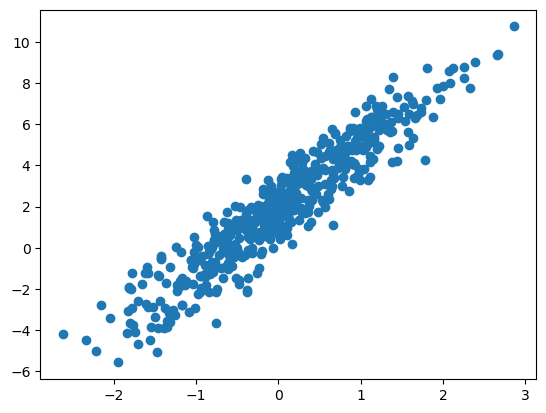

In [5]:
plt.scatter(X, y)
plt.show()

### 위의 랜덤데이터를 가지고 W = 3, b = 2를 구해보자

In [7]:
## 먼저 초기 랜덤값 셋팅
w = tf.Variable(5.)
b = tf.Variable(0.)

# 가중치 셋팅
lr = 0.03 # learning_rate : W을 얼마나 줄여나갈지 가중치 

In [8]:
## 학습 과정 기록
w_records = [w.numpy()]
b_records = [b.numpy()]
loss_records = []

# 전체 데이터를 100번 반복 학습하겠다.
for epoch in range(100): # 데이터셋 한번을 다 도는 것을 1 epoch 라 한다.
    
    # 매 epoch마다 학습
    # 연산 정의 / 연산 결과를 담은 tape 객체 반환
    with tf.GradientTape() as tape:
        y_hat = X * w + b
        loss = tf.reduce_mean(tf.square((y - y_hat)))
    
    # w와 b에 대한 loss의 변화율
    dw, db = tape.gradient(loss, [w, b])
    
    # b.assign_sub(a) : b변수에 a 만큼의 값을 뺀 나머지를 다시 b에 할당
    w.assign_sub(lr * dw) # w = w - w*lr
    b.assign_sub(lr * db) # b = b - b*lr
    
    # w, b, loss를 기록
    w_records.append(w.numpy())
    b_records.append(b.numpy())
    loss_records.append(loss.numpy())

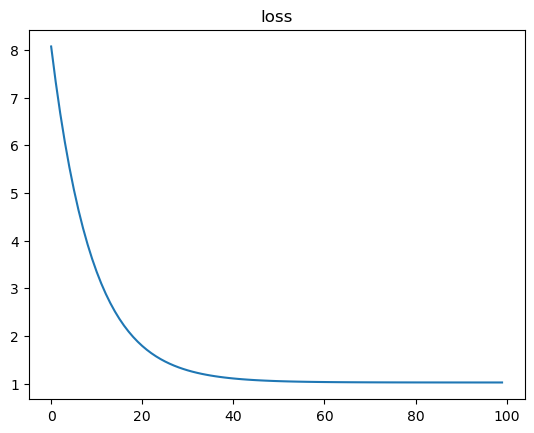

In [9]:
## loss가 줄어드는 과정을 보자

plt.plot(loss_records)
plt.title('loss')
plt.show()

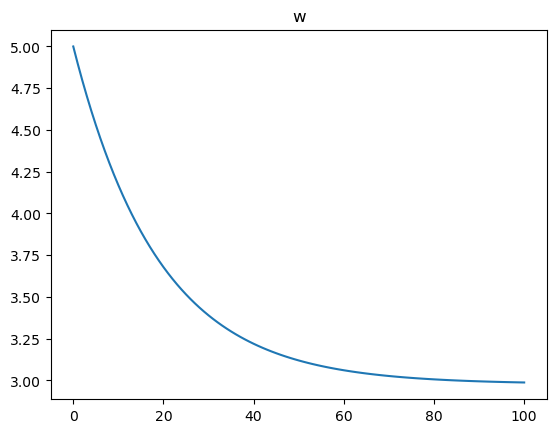

In [10]:
## w 가 줄어드는 과정을 보자

plt.plot(w_records)
plt.title('w')
plt.show()

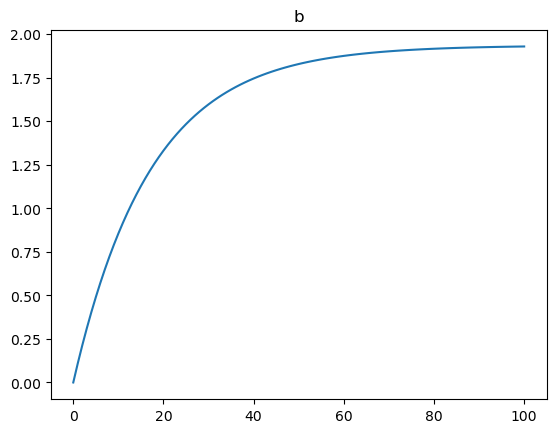

In [11]:
## b가 올라가는 과정을 보자

plt.plot(b_records)
plt.title('b')
plt.show()

In [22]:
print('실제 w : {:.3f} | 예측 w : {:.3f}'.format(W_true, w_records[100]))
print('실제 b : {:.3f} | 예측 b : {:.3f}'.format(B_true, b_records[100]))

실제 w : 3.000 | 예측 w : 2.987
실제 b : 2.000 | 예측 b : 1.930


### Dataset 당뇨병 진행도 예측 하기 

In [23]:
from sklearn.datasets import load_diabetes
import pandas as pd

diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names, dtype=np.float32)
df['const'] = np.ones(df.shape[0])
df.tail(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,const
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,1.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,1.0
441,-0.045472,-0.044642,-0.073030,-0.081413,0.083740,0.027809,0.173816,-0.039493,-0.004222,0.003064,1.0


### 먼저 OLS방식으로 진행

OLS방식설명

OLS란, Ordinary Least Squares의 약자로, 오차의 제곱을 최소화 하는 β 와 α 를 추정하는 방식이다.

쉽게 말해서, 잔차 제곱합의 미분식이 0이 되도록 하는 W를 직접 계산하라는 방식이다.

$$
y = XW
$$


$X$ 를 Feature, ,$w$를 가중치 벡터, $y$를 Target이라고 할 때, 

$X^T X$의 역행령이 존재 한다고 가정했을 때,  

아래의 식을 이용해 $w$의 추정치 $w^*$를 구해봅시다. 

$$
w^{\ast} = (X^TX)^{-1} X^T y
$$


Bias는 컬럼의 const 값으로 본다. ( X에 포함되있다)

-----

In [27]:
X = df
y = np.expand_dims(diabetes.target, axis=1).astype(np.float32)

In [32]:
XT = tf.transpose(X)
w = tf.matmul(tf.matmul(tf.linalg.inv(tf.matmul(XT, X)), XT), y)
                # (𝑋𝑇𝑋)^−1 ==> tf.linalg.inv(tf.matmul(XT, X))

# squeeze는 차원 중 사이즈가 1인 것을 찾아 스칼라값으로 바꿔 해당 차원을 제거한다.
y_pred = tf.squeeze(tf.matmul(X, w), axis=1)

print("예측 값  [0] : {:.3f}  |  실제 값[0] : {:.3f}".format(y_pred[0].numpy(), diabetes.target[0]))
print("예측 값 [19] : {:.3f}  |  실제 값[0] : {:.3f}".format(y_pred[19].numpy(), diabetes.target[19]))
print("예측 값 [31] : {:.3f}   |  실제 값[0] : {:.3f}".format(y_pred[31].numpy(), diabetes.target[31]))

#print("예측 진행도 [19] :", y_pred[19].numpy(), "실제 진행도 :", diabetes.target[19])
#print("예측 진행도[31]:", y_pred[31].numpy(), "실제 진행도 :", diabetes.target[31])

예측 값  [0] : 206.117  |  실제 값[0] : 151.000
예측 값 [19] : 124.018  |  실제 값[0] : 168.000
예측 값 [31] : 69.476   |  실제 값[0] : 59.000


### 이번에는, SGD 방식으로 구현해보세요!!

- Conditions
    - steepest gradient descents(전체 데이터 사용)
    - 가중치는 Gaussian normal distribution에서의 난수로 초기화함. 
    - step size  == 0.03
    - 100 iteration

In [33]:
lr = 0.03
num_iter = 100

-----

In [34]:
w_init = tf.random.normal([df.shape[1], 1], dtype=tf.float64) # x피처개수 * 1
w = tf.Variable(w_init)

In [35]:
for i in range(num_iter):
    with tf.GradientTape() as tape:
        y_hat = tf.matmul(X, w)
        loss = tf.reduce_mean((y_hat - y)**2)

    grad = tape.gradient(loss, w)
    w.assign_add(-lr * grad)


In [36]:
print("예측한 진행도 :", y_hat[0].numpy(),  "실제 진행도 :", diabetes.target[0])
print("예측한 진행도 :", y_hat[19].numpy(), "실제 진행도 :", diabetes.target[19])
print("예측한 진행도 :", y_hat[31].numpy(), "실제 진행도 :", diabetes.target[31])

예측한 진행도 : [153.11637599] 실제 진행도 : 151.0
예측한 진행도 : [149.73239217] 실제 진행도 : 168.0
예측한 진행도 : [147.66033944] 실제 진행도 : 59.0


# OLS vs SGD

OLS는 W를 식으로 만들어(추정식) W를 예측 (수학적 방식)

SGD는 W를 랜덤값으로 잡아놓고 직접 반복 계산을 통해 가중치를 업데이트(컴퓨팅 발전에 의한 방식)